In [1]:
import numpy as np
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup

In [2]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk
%matplotlib inline


In [3]:
Countries = {"SG":"Singapore","US":"United States","MY":"Malaysia","HK":"Hong Kong","ID":'Indonesia'}

Target_cities= {'US':
                      ['New York', 'Chicago', 'San Francisco', 'Austin', 'Seattle',
                  'Los Angeles', 'Philadelphia', 'Atlanta', 'Dallas',
                  'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston','Miami'],
                'SG':["Singapore"],
                'MY':['Kuala Lumpur','Johor Bahru','Shah Alam'],
                'HK':['Hong Kong'],
                'ID':['Jakarta','Batam','Surabaya']
                }

In [4]:
URL = {"SG":"https://www.indeed.com.sg/jobs",
       "US":"https://www.indeed.com/jobs",
       "MY":"https://www.indeed.com.my/jobs",
       "HK":"https://www.indeed.hk/jobs",
       "ID":"https://id.indeed.com/lowongan-kerja"
       
       }

In [5]:
max_results_per_city = 20000
#put data scientist as a placeholder, will be filled with the list of jobs later
parameters = {'q': 'data scientist', 'radius': '100', 'start':1}
#list of jobs
jobs = ['data scientist','data analyst']

In [ ]:
def scrape_page_to_df(url, url_params,country):
    """
    extract information from a results page and save to an existing csv
    :param url: url template
    :param url_params: a dictionary to feed to params argument in requests.get (based on the parameters I defined above, and I'll make a wrapper to do this below)
    :return: a pandas dataframe containing the extracted information
    """
    # create a empty dictionary to store extracted information
    scraped_data = {'location': [],
                  'company': [],
                  'title': [],
                  'salary': [],
                  'description': [],
                  'review': [],
                  'star': [],
                  'country':[]
                  }

    html = requests.get(url, params=url_params)

    # make sure the response status is ok
    assert html.status_code == requests.codes.ok

    soup = BeautifulSoup(html.text, 'lxml')

  #helper function to extract results

    def extract_results(soup):
        return soup.find_all('div', class_='result')

    results = extract_results(soup)

  #helper functions to extract information
    def extract_location(result):
        """extract job location"""
        try:
            location = result.find('span', class_='location').get_text().strip()
            return location
        except:
            return None


    def extract_company(result):
        """extract the name of the company"""
        try:
            company = result.find('span', class_='company').get_text().strip()
            return company
        except:
            return None

    def extract_title(result):
        """extract the job title"""
        try:
            title = result.find('a', attrs={'data-tn-element': "jobTitle"}).get('title')
            return title
        except:
            return None


    def extract_salary(result):
        """extract the salary"""
        try:
            salary = result.find('td', class_='snip').\
            find('span', class_='no-wrap').\
            get_text().strip()
            return salary
        except:
            return None


    def extract_description(result):
        """extract job description snippet"""
        try:
            description = result.find('span', class_='summary').get_text().strip()
            return description
        except:
            return None


    def extract_review(result):
        """extract the number of reviews for the company"""
        try:
            review = result.find('a', attrs={'data-tn-element': "reviewStars"})
            review = review.find('span', class_="slNoUnderline")
            review = review.get_text().strip()
            # extract only the number
            review = review.replace(',', '').replace(' reviews', '')
            return review
        except:
            return None            

    
    def extract_star(result):
        """extract a number (width) that is proportional to the number of stars
        shown for the company"""
        try:
            # the 'style' attribute dictates how many stars are filled with color
            star = result.find('span', class_='rating').get('style')
            # extract only the number
            star = star.replace('width:', '').replace('px', '')
            return star
        except:
            return None


    # append extracted info to the correspond list
    for result in results:
        scraped_data['location'].append(extract_location(result))
        scraped_data['company'].append(extract_company(result))
        scraped_data['title'].append(extract_title(result))
        scraped_data['salary'].append(extract_salary(result))
        scraped_data['description'].append(extract_description(result))
        scraped_data['review'].append(extract_review(result))
        scraped_data['star'].append(extract_star(result))
        scraped_data['country'].append(country)

      # convert the dictionary to a pandas dataframe and returns it
    return pd.DataFrame(scraped_data)


In [ ]:
def remove_duplicates(df):
    """remove duplicates and returns a new df"""
    
    nrows_before = df.shape[0]
    df.drop_duplicates(subset=['company', 'country','description',
                               'location', 'salary', 'title'],
                       keep='last', inplace=True)
    nrows_after = df.shape[0]
    
    print('{} rows remain after removing duplicates from {} rows.'.format(
        nrows_after, nrows_before))
    print('{} rows have salary info; {} rows have yearly salary info.'.format(
      df.salary.notnull().sum(), df.salary.str.contains('year').sum()))
    return df

In [ ]:
def scrapper(CountryCode):
    print('Current system time: {}'.format(time.ctime()))
    
   
  
    # scrape data and save to dataframe
    start_time = time.time()
    
    #Retrieve Parameters to scrape with based on input of Country Code
    url = URL[CountryCode]
    locations = Target_cities[CountryCode]
    country = Countries[CountryCode]
    
    #Create an empty place holder df, search through every location in that country, but only 1 results, just to get the title and columns
    df = scrape_page_to_df(url,parameters,country)
    
    
    for tempat in locations:
        for kerja in jobs:
            for start in range(0, max_results_per_city, 10):
            
              
                url_params = parameters.copy()
                #update the job with the target job that we want, city for target city that we are looking for and start refers to the current page number being scrapped
                url_params.update({'l': tempat,'q': kerja, 'start': start})


                #insert code to put the scrap stuff into a df here, after each round of loop, concat into a df
                df = pd.concat([df,scrape_page_to_df(url, url_params,country)],axis=0)
              
        print('Finished scraping {}'.format(tempat))
    total_time = (time.time() - start_time) / 60
    print('Scraping run time: {:.1f} minutes'.format(total_time))

    
    
    
    # remove duplicates
    df = remove_duplicates(df)
    print('Script finished at {}\n'.format(time.ctime()))
    
    #returns the final df
    return df

In [ ]:
#GVV = scrapper('SG')

In [ ]:
GVV.shape

In [ ]:
GVV.head()

In [6]:
title = []
company = []
location = []
salary = []
summary = []
skills = []

def scrape_city(city, results):
    """    
    Args
    ====
    
    city : (str)
        The city you wish to scrape from.
    
    pages : (int)
        The number of search results you want
        for the city.
    """
    
    def get_title(soup): 
        jobs = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            for a in div.find_all('a', attrs={'data-tn-element':'jobTitle'}):
                jobs.append(a['title'])
        return jobs

    def get_company(soup): 
        companies = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            company = div.find_all('span', attrs={'class':'company'})
            if len(company) > 0:
                for b in company:
                    companies.append(b.text.strip())
            else:
                sec_try = div.find_all('span', attrs={'class':'result-link-source'})
                for span in sec_try:
                    companies.append(span.text.strip())

        return companies

    def get_location(soup): 
        locations = []
        spans = soup.find_all('span', attrs={'class': 'location'})
        for span in spans:
            locations.append(span.text)
        return locations
    
    def get_sala(soup): 
        salaries = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            try:
                salaries.append(div.find('nobr').text)
            except:
                try:
                    div_two = div.find('div', attrs={'class':'sjcl'})
                    div_three = div_two.find('div')
                    salaries.append(div_three.text.strip())
                except:
                    salaries.append('NA')
        return salaries

    def get_salary(soup): 
        salaries = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            try:
                salaries.append(div.find('span', attrs={'class': 'no-wrap'}).text)
            except:
                salaries.append('NA')
        return salaries    
    
    def get_summary(soup): 
        summaries = []
        spans = soup.find_all('span', attrs={'class': 'summary'})
        for span in spans:
            summaries.append(span.text.strip())
        return summaries
    
    def get_skill(soup): 
        skills = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            try:
                skills.append(div.find('span', attrs={'class': 'experienceList'}).text)
            except:
                skills.append('NA')
        return skills  
    
    for start in range (0, results, 50):
        url = 'https://www.indeed.com/jobs?q=' + 'data+scientist' + '&l=' + city \
            + '&limit=50&radius=25' + '&start=' + str(start)
        request = requests.get(url)
        soup = BeautifulSoup(request.text, 'html.parser')
    
        title.extend(get_title(soup))
        company.extend(get_company(soup))
        location.extend(get_location(soup))
        salary.extend(get_salary(soup))
        summary.extend(get_summary(soup))
        skills.extend(get_skill(soup))
        time.sleep(2)
        print start, 'done.'

In [7]:
Target_cities['US']

['New York',
 'Chicago',
 'San Francisco',
 'Austin',
 'Seattle',
 'Los Angeles',
 'Philadelphia',
 'Atlanta',
 'Dallas',
 'Pittsburgh',
 'Portland',
 'Phoenix',
 'Denver',
 'Houston',
 'Miami']

In [ ]:
#for cities in Target_cities['US']:
    scrape_city(cities , 2000)

In [ ]:
columns =[title, company, location, salary, summary, skills]

In [8]:
import cPickle as cpickle

In [12]:
with open('indeed_final.pkl','rb') as f:
    df = cpickle.load(f)

In [13]:
df.head()

,title,company,location,salary,summary,skill,r1,per,r2,annual_salary,high_salary
0,Data Scientist,Honeywell,Arizona,NA,You Must Have Bachelor’s degree in Predictive ...,"Machine Learning, R, BI, SPSS, Hadoop, Sas, Da...",NaN,NaN,NaN,NaN,0
1,Data Scientist,Cyient,Arizona,NA,Prior experience in R and data analytics is pr...,"SPSS, Machine Learning, R, Sas, Tableau, Python",NaN,NaN,NaN,NaN,0
2,Data Scientist,Tuft & Needle,Arizona,NA,"For insights, we use Looker to give other team...","Machine Learning, R, Data Science, Python",NaN,NaN,NaN,NaN,0
3,Data Scientist,Silicon Valley Bank,Arizona,NA,In order to design and create information foun...,"Machine Learning, PL/SQL, BI, Data Mining, Ora...",NaN,NaN,NaN,NaN,0
4,Data Scientist - Productivity Applications,GoDaddy,Arizona,NA,Your primary focus will be in applying data mi...,"Hive, SQL Server, Machine Learning, R, MySQL, ...",NaN,NaN,NaN,NaN,0


In [14]:
df.shape

(10156, 11)

In [15]:
df.location.value_counts()

California        2261
New York          1028
Massachusetts      985
Virginia           822
Washington         801
Maryland           743
Texas              682
Illinois           682
Pennsylvania       484
Colorado           439
Florida            429
North Carolina     382
Connecticut        235
Arizona            183
Name: location, dtype: int64

In [16]:
df.drop(['r1','per','r2','annual_salary','high_salary'],axis = 1,inplace = True)

In [17]:
df.head()

,title,company,location,salary,summary,skill
0,Data Scientist,Honeywell,Arizona,NA,You Must Have Bachelor’s degree in Predictive ...,"Machine Learning, R, BI, SPSS, Hadoop, Sas, Da..."
1,Data Scientist,Cyient,Arizona,NA,Prior experience in R and data analytics is pr...,"SPSS, Machine Learning, R, Sas, Tableau, Python"
2,Data Scientist,Tuft & Needle,Arizona,NA,"For insights, we use Looker to give other team...","Machine Learning, R, Data Science, Python"
3,Data Scientist,Silicon Valley Bank,Arizona,NA,In order to design and create information foun...,"Machine Learning, PL/SQL, BI, Data Mining, Ora..."
4,Data Scientist - Productivity Applications,GoDaddy,Arizona,NA,Your primary focus will be in applying data mi...,"Hive, SQL Server, Machine Learning, R, MySQL, ..."


In [18]:
df.location.value_counts( sort=True)

California        2261
New York          1028
Massachusetts      985
Virginia           822
Washington         801
Maryland           743
Texas              682
Illinois           682
Pennsylvania       484
Colorado           439
Florida            429
North Carolina     382
Connecticut        235
Arizona            183
Name: location, dtype: int64

In [19]:
CountStatus = pd.value_counts(df['location'].values, sort=True)

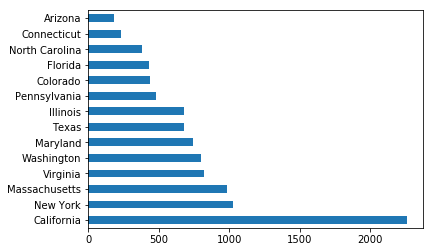

In [20]:
CountStatus.plot.barh()

In [21]:
df.loc[df['salary']=='NA','salary'] = np.nan

In [22]:
df.head()

,title,company,location,salary,summary,skill
0,Data Scientist,Honeywell,Arizona,NaN,You Must Have Bachelor’s degree in Predictive ...,"Machine Learning, R, BI, SPSS, Hadoop, Sas, Da..."
1,Data Scientist,Cyient,Arizona,NaN,Prior experience in R and data analytics is pr...,"SPSS, Machine Learning, R, Sas, Tableau, Python"
2,Data Scientist,Tuft & Needle,Arizona,NaN,"For insights, we use Looker to give other team...","Machine Learning, R, Data Science, Python"
3,Data Scientist,Silicon Valley Bank,Arizona,NaN,In order to design and create information foun...,"Machine Learning, PL/SQL, BI, Data Mining, Ora..."
4,Data Scientist - Productivity Applications,GoDaddy,Arizona,NaN,Your primary focus will be in applying data mi...,"Hive, SQL Server, Machine Learning, R, MySQL, ..."


In [23]:
nsf = df.dropna()

In [24]:
nsf.shape

(595, 6)

In [25]:
nsf.head()

,title,company,location,salary,summary,skill
28,App Sys Analyst/Prog -Intrmed,Northern Arizona University,Arizona,56500-61500-year,Employees offered a position will be eligible ...,"Perl, C/C++, Java, Rust, Python"
31,Research Scientist (Part Time),University of Arizona,Arizona,80000-96000-year,Scientists used to view the aging brain as an ...,"TensorFlow, Machine Learning, C/C++, MATLAB, I..."
37,Management Research Analyst Senior,Arizona State University,Arizona,56880-72000-year,"Develops, maintains, and utilizes extensive da...","SQL Server, BI, Tableau"
38,PUBLIC INFORMATION OFFICER,State of Arizona,Arizona,50000-75000-year,"The ability to work with scientists, engineers...",NA
39,"Assistant Research Scientist, Basic Medical Sc...",University of Arizona,Arizona,34000-year,The University of Arizona Cancer Center in ass...,Oncology


In [26]:
nsf.salary.value_counts()

59708-72246-year                      8
70286-88213-year                      7
130692-174569-year                    6
150000-year                           6
120000-150000-year                    6
94796-123234-year                     6
15-hour                               5
150000-180000-year                    5
100000-150000-year                    5
180000-year                           5
32900-59100-year                      4
120000-140000-year                    4
20.96-hour                            4
80000-100000-year                     4
90000-120000-year                     4
5400-6500-month                       4
160000-year                           4
100000-130000-year                    4
220000-year                           4
55000-year                            3
70000-90000-year                      3
85816-131833-year                     3
51600-77400-year                      3
120000-year                           3
23.06-28.44-hour                      3


In [27]:
nsf.salary = map(lambda x: x.replace('Estimated salary: ', ''), nsf.salary)

C:\Users\Bhushan\Anaconda2\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [28]:
nsf.salary.values

array([u'56500-61500-year', u'80000-96000-year', u'56880-72000-year',
       u'50000-75000-year', u'34000-year', u'56573-75000-year',
       u'50000-55000-year', u'65000-year', u'62046-80657-year',
       u'50000-55000-year', u'47000-year', u'101938-148550-year',
       u'39173-59948-year', u'47659-year', u'10.16-12.52-hour',
       u'37113-73098-year', u'12.25-17.54-hour', u'65000-83000-year',
       u'82000-104000-year', u'66000-84000-year', u'12.25-17.54-hour',
       u'65000-83000-year', u'47000-56750-year', u'80000-90000-year',
       u'130000-150000-year', u'50000-year', u'10.87-15.12-hour',
       u'10.82-14.00-hour', u'10.87-13.53-hour', u'10.16-hour',
       u'44629-61782-year', u'38262-53082-year', u'29008-38000-year',
       u'31125-42843-year', u'29443-39307-year', u'10.00-12.84-hour',
       u'13.53-16.00-hour', u'75000-year', u'80000-100000-year',
       u'130000-140000-year', u'90000-140000-year', u'56573-75000-year',
       u'17-20-hour', u'100000-115000-year', u'110000

In [29]:
nsf['mean'] = nsf['salary'].str.extractall('(\d+)')[0].unstack().astype(float).mean(1)

C:\Users\Bhushan\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
nsf.head()

,title,company,location,salary,summary,skill,mean
28,App Sys Analyst/Prog -Intrmed,Northern Arizona University,Arizona,56500-61500-year,Employees offered a position will be eligible ...,"Perl, C/C++, Java, Rust, Python",59000.0
31,Research Scientist (Part Time),University of Arizona,Arizona,80000-96000-year,Scientists used to view the aging brain as an ...,"TensorFlow, Machine Learning, C/C++, MATLAB, I...",88000.0
37,Management Research Analyst Senior,Arizona State University,Arizona,56880-72000-year,"Develops, maintains, and utilizes extensive da...","SQL Server, BI, Tableau",64440.0
38,PUBLIC INFORMATION OFFICER,State of Arizona,Arizona,50000-75000-year,"The ability to work with scientists, engineers...",NA,62500.0
39,"Assistant Research Scientist, Basic Medical Sc...",University of Arizona,Arizona,34000-year,The University of Arizona Cancer Center in ass...,Oncology,34000.0


In [43]:
m1 = nsf['salary'].str.contains('month')
m2 = nsf['salary'].str.contains('day')
m3 = nsf['salary'].str.contains('hour')
nsf['annsal'] =np.select([m1, m2, m3], 
                          [nsf['mean'] * 12,nsf['mean'] * 260,nsf['mean']* 8* 5* 52], default=nsf['mean'])

C:\Users\Bhushan\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [44]:
nsf.head()

,title,company,location,salary,summary,skill,mean,annual salary,annualsalary,annsal
28,App Sys Analyst/Prog -Intrmed,Northern Arizona University,Arizona,56500-61500-year,Employees offered a position will be eligible ...,"Perl, C/C++, Java, Rust, Python",59000.0,59000.0,59000.0,59000.0
31,Research Scientist (Part Time),University of Arizona,Arizona,80000-96000-year,Scientists used to view the aging brain as an ...,"TensorFlow, Machine Learning, C/C++, MATLAB, I...",88000.0,88000.0,88000.0,88000.0
37,Management Research Analyst Senior,Arizona State University,Arizona,56880-72000-year,"Develops, maintains, and utilizes extensive da...","SQL Server, BI, Tableau",64440.0,64440.0,64440.0,64440.0
38,PUBLIC INFORMATION OFFICER,State of Arizona,Arizona,50000-75000-year,"The ability to work with scientists, engineers...",NA,62500.0,62500.0,62500.0,62500.0
39,"Assistant Research Scientist, Basic Medical Sc...",University of Arizona,Arizona,34000-year,The University of Arizona Cancer Center in ass...,Oncology,34000.0,34000.0,34000.0,34000.0


In [55]:
plt.bar(np.arange(,s)
plt.show()

numpy.ndarray

count       595.000000
mean      90298.774790
std       43143.029915
min         886.000000
25%       57437.500000
50%       82500.000000
75%      120000.000000
max      240000.000000
Name: annsal, dtype: float64

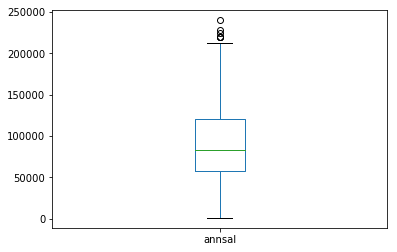

In [63]:
nsf['annsal'].plot.box()
nsf['annsal'].describe()

Int64Index([   28,    31,    37,    38,    39,    44,    46,    50,    52,
               55,
            ...
            13644, 13681, 13697, 13734, 13846, 13847, 13874, 13883, 13884,
            14176],
           dtype='int64', length=595)